# Assignment 01 - Naive Bayes Classifier

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import stem
import seaborn as sns
import collections

## 1. Data Loading

In [28]:
dataset_df = pd.read_csv('imdb_master.csv', encoding_errors = 'ignore')
dataset_df

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
...,...,...,...,...,...
99995,99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt


In [29]:
# check if the labels in these two columns are clean
print(dataset_df['type'].unique())
print(dataset_df['label'].unique())

['test' 'train']
['neg' 'pos' 'unsup']


In [30]:
# split the data set into a training set and a test set
training_set = dataset_df[dataset_df.type == 'train']      
test_set = dataset_df[dataset_df.type == 'test']
training_set['review'][25000]             # an example text                   

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [31]:
# check if there is any null or NA in the training set
np.sum(np.sum(training_set.isnull()))

0

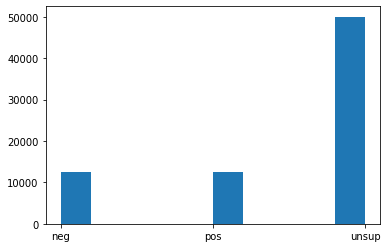

In [32]:
# check label distribution
plt.hist(training_set.label)
plt.show()

## 2. Text Preprocessing

### 2.1 Training text generation 
use ' '.join() to link the texts together, then do case folding

In [33]:
# this cell is to concatenate the texts in 'pos' and 'neg' together separately
# and to turn all uppercase letters in the text into lowercase
training_text_pos_ser = training_set['review'][training_set['label'] == 'pos']
training_text_neg_ser = training_set['review'][training_set['label'] == 'neg']
training_text_pos = ' '.join(training_text_pos_ser).lower()
training_text_neg = ' '.join(training_text_neg_ser).lower()
print(len(training_text_pos))
print(len(training_text_neg))

16852166
16299842


### 2.2 Case folding and tokenization
use 'word_tokenize' from nltk.tokenize for tokenization, and use MWETokenizer to re-tokenize the token lists (to deal with negate)

In [34]:
# tokenize the 'pos' text. This step may take several minutes
training_text_pos_tokens_backup = word_tokenize(training_text_pos)
training_text_pos_tokens = training_text_pos_tokens_backup.copy()
print(len(training_text_pos_tokens))

3559658


In [35]:
# tokenize the 'neg' text. This step may take several minutes
training_text_neg_tokens_backup = word_tokenize(training_text_neg)
training_text_neg_tokens = training_text_neg_tokens_backup.copy()
print(len(training_text_neg_tokens))

3505116


In [36]:
# retokenize bigrams like ("n't", "like"), ("not", "like") or ("never", "like") as "n't_like", "not_like" and "never_like" to deal with negate
# This is the factor 4 I investigated, for more details, please the report
# this cell is to make a re-tokenize list for re-tokenization
training_text_tokens = training_text_pos_tokens + training_text_neg_tokens     # training_text_tokens is a combination of 'pos' and 'neg'
training_text_tokens_set = set(training_text_tokens)                           # use 'set' to accelerate the search process                    
MWE_list = []                                                                  # a re-tokenize list for re-tokenization

bigram = list(ngrams(training_text_tokens, 2))          # all the bigrams
bigram_freq = collections.Counter(bigram)               # the counts of all the bigrams

for word in training_text_tokens_set:                   # if the count of a bigram like ("n't", 'like') is not 0, add this bigram to the list
    if bigram_freq[("n't", word)] != 0:                 # to the MWE list
        MWE_list.append(("n't", word))
    if bigram_freq[("not", word)] != 0:
        MWE_list.append(("not", word))
    if bigram_freq[("never", word)] != 0:
        MWE_list.append(("never", word)) 
print(len(MWE_list))

6650


In [37]:
# retokenize the 'pos' token list and 'neg' token list
MWE_tokenizer = MWETokenizer(MWE_list)
training_text_pos_tokens = MWE_tokenizer.tokenize(training_text_pos_tokens)
training_text_neg_tokens = MWE_tokenizer.tokenize(training_text_neg_tokens)
print(len(training_text_pos_tokens))
print(len(training_text_neg_tokens))

3528394
3465118


### 2.3 Punctuation marks and stopwords removing
use nltk stopwords list as the list of the words to remove

In [38]:
# this is a binary search function for searching the range of a token
def searchRange(nums, target):
    if len(nums) == 0:
        ans_list = [-1,-1]
        return ans_list
    
    ans_list = []
    n = len(nums)
    l = 0
    r = n-1
    mid = int((l+r)/2)
    
    while l != r:
    
        while nums[mid] < target:
            if l == r:
                break
                      
            l = mid + 1
            mid = int((l+r)/2)
            if l == r:
                break

        while nums[mid] > target:
            if l == r:
                break
            r = mid
            mid = int((l+r)/2)
            if l == r:
                break
        
        if nums[mid] == target:
            break

    if nums[mid] == target:
        l1 = l
        r1 = mid
        l2 = mid
        r2 = r
        mid1 = int((l1+r1)/2)
        mid2 = int((l2+r2)/2)
        
        while l1 != r1:
            
            while nums[mid1] < target:
                if nums[mid1+1] == target:
                    mid1 = mid1 + 1
                    break
                l1 = mid1 + 1
                mid1 = int((l1+r1)/2)
                if l1==r1:
                    break
            while nums[mid1] == target:
                if nums[mid1-1] != target:
                    break
                else:
                    r1 = mid1
                    mid1 = int((l1+r1)/2)
                if l1==r1:
                    break
            if l1 == r1:
                break
            if nums[mid1] == target and nums[mid1-1] != target:
                break
                
        while l2 != r2:
            
            while nums[mid2] > target:      
                if nums[mid2-1] == target:  
                    mid2 = mid2 - 1 
                    break
                r2 = mid2                   
                mid2 = int((l2+r2)/2)       
                if l2==r2:
                    break
            while nums[mid2] == target:     
                if mid2+1 <= n-1 and nums[mid2+1] != target:  
                    break
                if mid2+1 > n-1:
                    break
                else:                       
                    l2 = mid2+1
                    mid2 = int((l2+r2)/2)
                if l2==r2:
                    break
            if l2 == r2:
                break
            if nums[mid2] == target and nums[mid2+1] != target:
                break
        
        ans_list.append(mid1)
        ans_list.append(mid2)
        
    else:
        ans_list.append(-1)
        ans_list.append(-1)
        
    return ans_list

In [39]:
# check and modify the stopwords list
# remove all the negate words form the list is actually not necessary because there should be no negate words in the token list now
nltk_sw = set(stopwords.words('english')) - {"not", "aren't", "don't", "weren't", "doesn't", "haven't", "wouldn't", "mightn't", "shan't", 
                                             "hadn't", "couldn't", "isn't", "wasn't", "won't", "hasn't", "shouldn't", "didn't", "needn't", "mustn't"}
print(nltk_sw)

{'below', 'out', 'all', 'your', 'how', 'any', 'same', 'me', 'against', 'their', 'here', 'under', 'to', 'each', 're', 'doing', 'whom', 'why', 'my', "that'll", 'no', 'above', 'aren', 'needn', 'wouldn', 'other', "it's", 'few', 'been', 'about', 'he', 'themselves', "should've", 'ain', 'in', 'theirs', 's', 'doesn', 've', 'are', 'or', 'yours', 'hasn', 'and', 'itself', 'so', "you're", 'the', "you'd", 'when', 'own', 'wasn', 'which', 'further', 'shan', 'until', 'i', 'don', 'from', 'by', 'his', 'does', 'do', 'them', 'most', 'up', 'm', 'is', 'they', 'into', 'it', 'didn', 'haven', 'did', 'on', 'y', 'herself', 'being', 'down', 'before', 'were', 'some', 'have', 'as', 'while', 'at', 'during', 'himself', "you've", 'am', 'this', 'was', 'for', 'should', 'after', 'ma', 'our', 'those', 'where', 'because', 'of', 'if', 'you', 'yourself', 'nor', 'weren', 'has', 'her', 'there', 'that', 'mustn', "she's", 'ourselves', 'an', 'myself', 'off', 'hadn', 'only', 'again', 'o', 'through', 'its', 'than', 'a', 'what', 'th

In [40]:
# remove punctuation marks
# This is the factor 3 I investigated, for more details, please the report
def remove_punctuation_mark(token_list,target='a'):
    token_list.sort()
    word_range = searchRange(token_list, target)
    del token_list[:word_range[0]+1]                       # delete all the tokens from the first token to the first 'a'

remove_punctuation_mark(training_text_pos_tokens)
remove_punctuation_mark(training_text_neg_tokens)
print(len(training_text_pos_tokens))
print(len(training_text_neg_tokens))

2940311
2865731


In [41]:
# remove stopwords
def remove_stop_words(token_list):
    token_list.sort()
    for word in nltk_sw:
        word_range = searchRange(token_list, word)         # search the range of a specific word
        if word_range[0] != -1:                            # if the word in nltk_sw does not exist in the token list, the range will be (-1,-1)
            del token_list[word_range[0]:word_range[1]+1]  # delete all the same word in the token list
            
remove_stop_words(training_text_pos_tokens)
remove_stop_words(training_text_neg_tokens)
print(len(training_text_pos_tokens))
print(len(training_text_neg_tokens))

1564650
1508417


### 2.4 Stemming  
use porter stemer to stem tokens

In [42]:
porter_stemer = stem.porter.PorterStemmer()

In [43]:
training_text_pos_tokens_stm = [porter_stemer.stem(word) for word in training_text_pos_tokens]
training_text_neg_tokens_stm = [porter_stemer.stem(word) for word in training_text_neg_tokens]

In [ ]:
# This is the factor 2 I investigated, for more details, please the report
# training_text_pos_tokens_stm = [word_net_lemma.lemmatize(word) for word in training_text_pos_tokens]
# training_text_neg_tokens_stm = [word_net_lemma.lemmatize(word) for word in training_text_neg_tokens]

In [44]:
training_text_tokens_stm = training_text_pos_tokens_stm + training_text_neg_tokens_stm   
training_text_tokens_stm_set = set(training_text_tokens_stm)

In [45]:
# count unigram frequency for each list
def unigram_freq(token_list):
    unigram_list = list(ngrams(token_list,1))
    unigram_freq = collections.Counter(unigram_list)
    return unigram_freq

training_text_pos_tokens_stm_unigram_freq = unigram_freq(training_text_pos_tokens_stm)
training_text_neg_tokens_stm_unigram_freq = unigram_freq(training_text_neg_tokens_stm)
training_text_tokens_stm_unigram_freq = unigram_freq(training_text_tokens_stm)

## 3. Training

In [46]:
pos_count = len(training_set[training_set.label == 'pos'])
neg_count = len(training_set[training_set.label == 'neg'])
total = pos_count + neg_count
P_pos = pos_count/total
P_neg = neg_count/total
V = len(training_text_tokens_stm_unigram_freq)                                  # vocabulary is the length of unigram frequency 

# the parameters are: a specific token; the 'pos' or the 'neg' token list; the unigram frequency of that list
# add-k is the factor 1 I investigated, for more details, please the report
def P_token_cls(token, stmed_token_list, unigram_freq):                         # to calculate P(word|class)
    P_token_cls = (unigram_freq[(token,)]+500)/(len(stmed_token_list)+500*V)    # unigram_freq[(token,)] is the count of a specific token
    return P_token_cls                                                          # len(stmed_token_list) is word count of a token list

# calculate log probabilities of the words in a text and add them up
# each test_text_tokens_stm is a target text to classify
def cond_prob(test_text_tokens_stm):
    log_pos_cond_prob = log_neg_cond_prob = log_unsup_cond_prob = 0             # initialize the log probability
    for token in test_text_tokens_stm:                                          # for each token in the target text
        if token in training_text_tokens_stm_set:                               # if it is also a token in the training set                                                
            P_token_pos = P_token_cls(token, training_text_pos_tokens_stm, training_text_pos_tokens_stm_unigram_freq)   
            P_token_neg = P_token_cls(token, training_text_neg_tokens_stm, training_text_neg_tokens_stm_unigram_freq)   
            log_pos_cond_prob = log_pos_cond_prob + np.log(P_token_pos)         # calculate the log probability of that token
            log_neg_cond_prob = log_neg_cond_prob + np.log(P_token_neg)         # and add all the log probabilities up
    return log_pos_cond_prob, log_neg_cond_prob

# a function to convert the target text to a stemmed token list
def text_to_stmed_token_list(text):
    text_tokens = word_tokenize(text)                                           # tokenize
    retokenized_tokens = MWE_tokenizer.tokenize(text_tokens)                    # retokenize
    text_tokens_stm = [porter_stemer.stem(word) for word in retokenized_tokens] # stemming
    #text_tokens_stm = [word_net_lemma.lemmatize(word) for word in retokenized_tokens]
    return text_tokens_stm  

# the final step of classification
def classify(log_pos_cond_prob, log_neg_cond_prob):
    pos = log_pos_cond_prob + np.log(P_pos)
    neg = log_neg_cond_prob + np.log(P_neg)   
    if pos > neg:
        res = 'pos'
        return res
    if neg > pos:
        res = 'neg'
        return res

In [47]:
# a classification pipeline. Take a target text and return its predicted label
def classify_pipeline(target_text):
    target_text_token_stm = text_to_stmed_token_list(target_text)               # text preprocessing
    log_pos_cond_prob, log_neg_cond_prob = cond_prob(target_text_token_stm)     # calculate probabilities
    res = classify(log_pos_cond_prob, log_neg_cond_prob)                        # classify
    return res

# for all test cases, predict their label and compare the results with tags
cor_mat = np.zeros(4).reshape(2,2)    # horizontal: gold positive (the first dimension), vertical: system positive (the second dimension)
for i in range(total):
    tag = test_set['label'][i]
    prediction = classify_pipeline(test_set['review'][i])
    if tag == prediction == 'pos':               # tp
        cor_mat[0][0] = cor_mat[0][0] + 1
    elif tag == prediction == 'neg':             # tn
        cor_mat[1][1] = cor_mat[1][1] + 1
    elif tag == 'pos' and prediction == 'neg':   # fn
        cor_mat[1][0] = cor_mat[1][0] + 1
    elif tag == 'neg' and prediction == 'pos':   # fp
        cor_mat[0][1] = cor_mat[0][1] + 1

cor_mat   

array([[10148.,  1852.],
       [ 2352., 10648.]])

In [48]:
cor_mat_df = pd.DataFrame(cor_mat)
cor_mat_df.columns = ['gold positive', 'gold negative']
cor_mat_df.index = ['system positive', 'system negative']
cor_mat_df

,gold positive,gold negative
system positive,10148.0,1852.0
system negative,2352.0,10648.0


## 4. Evaluation

In [49]:
precision = cor_mat[0][0] / (cor_mat[0][0] + cor_mat[0][1])                  # precision = tp / (tp + fp)
recall = cor_mat[0][0] / (cor_mat[0][0] + cor_mat[1][0])                     # recall = tp / (tp + fn)
F1 = (2*precision*recall) / (precision + recall)                             # F1 = 2*P*R / (P + R)
print(precision)
print(recall)
print(F1)

0.8456666666666667
0.81184
0.8284081632653061


Text(69.0, 0.5, 'Output')

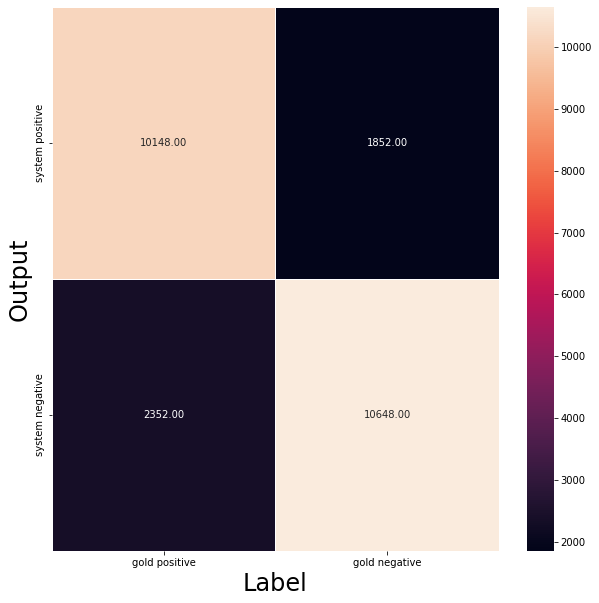

In [50]:
plt.figure(figsize=(10,10))                                                  # create a Figure object
sns.heatmap(cor_mat_df,annot=True,fmt ='.2f',linewidths =0.5,color='blue')   # use heatmap function in Seaborn to plot the figure
plt.xlabel('Label',fontsize=24)
plt.ylabel('Output',fontsize=24)

***
CHEN Chen a1819099, 16-Mar-2022